In [1]:
import pickle
from glob import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from statistics import median, quantiles

In [5]:
os.chdir('/home/s2971992/projects/gptnl')

In [8]:
# vocab_sizes = list(range(10, 201, 10))
vocab_sizes = list(range(10, 91, 10))

In [9]:
median_lengths = []

for vocab_size in vocab_sizes:
    lengths_path = f'data/nld/preparation/prepared/data-{str(vocab_size).zfill(3)}k.pkl.lengths'
    with open(lengths_path, 'rb') as f:
        lengths = pickle.load(f)

    l = int(median(lengths))
    print(vocab_size, l)
    median_lengths.append(l)

10 400
20 364
30 347
40 338
50 331
60 326
70 322
80 319
90 317


In [11]:
q_coverages = []
coverages = []

for vocab_size in vocab_sizes:
    coverages_path = f'data/nld/preparation/prepared/data-{str(vocab_size).zfill(3)}k.pkl.coverage'
    with open(coverages_path, 'rb') as f:
        covs = pickle.load(f)

    c = int(quantiles(covs.values(), n=4)[0])
    print(vocab_size, c)
    q_coverages.append(c)
    coverages.append(covs)

10 60491
20 22544
30 12348
40 8021
50 5711
60 4290
70 3369
80 2711
90 2244


In [12]:
# for v, cs in zip(vocab_sizes, coverages):
#     ids = sorted(cs, key=cs.get, reverse=True)
#     counts = [cs[i] for i in ids]

#     plt.plot(counts)
#     # plt.title(str(v) + 'k')
# plt.yscale('log')
# plt.show()

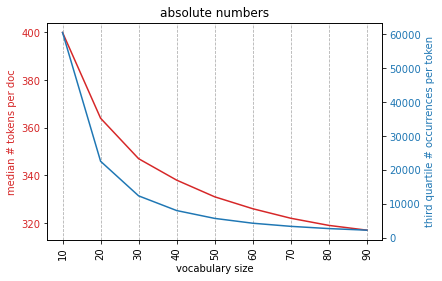

In [13]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
ax1.set_title('absolute numbers')
ax1.set_xlabel('vocabulary size')
ax1.set_xticks(vocab_sizes)
ax1.set_xticks(vocab_sizes, minor=True)
ax1.grid(which='both', axis='x', linestyle='--')

color = 'tab:red'
ax1.plot(vocab_sizes, median_lengths, color=color)
ax1.set_ylabel('median # tokens per doc', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(vocab_sizes, q_coverages, color=color)
ax2.set_ylabel('third quartile # occurrences per token', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

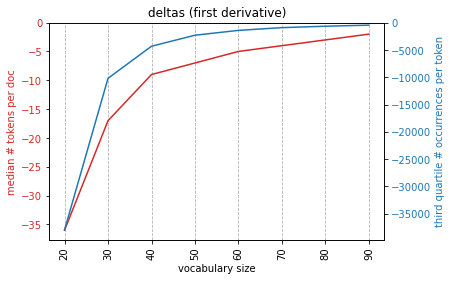

In [14]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
ax1.set_title('deltas (first derivative)')
ax1.set_xlabel('vocabulary size')
ax1.set_xticks(vocab_sizes)
ax1.set_xticks(vocab_sizes, minor=True)
ax1.grid(which='both', axis='x', linestyle='--')

color = 'tab:red'
ax1.plot(vocab_sizes[1:], np.diff(median_lengths), color=color)
# ax1.set_yscale('symlog')
ax1.set_ylim(top=0)
ax1.set_ylabel('median # tokens per doc', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(vocab_sizes[1:], np.diff(q_coverages), color=color)
# ax2.set_yscale('symlog')
ax2.set_ylim(top=0)
ax2.set_ylabel('third quartile # occurrences per token', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

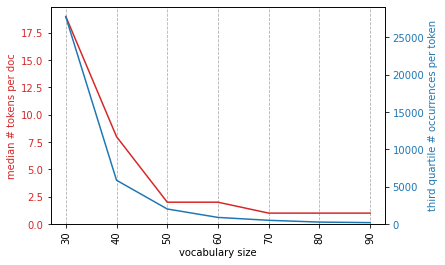

In [23]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
# ax1.set_title('delta-deltas (second derivative)')
ax1.set_xlabel('vocabulary size')
ax1.set_xticks(vocab_sizes)
ax1.set_xticks(vocab_sizes, minor=True)
ax1.grid(which='both', axis='x', linestyle='--')

color = 'tab:red'
ax1.plot(vocab_sizes[2:], np.diff(np.diff(median_lengths)), color=color)
ax1.set_ylim(bottom=0)
ax1.set_ylabel('median # tokens per doc', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(vocab_sizes[2:], np.diff(np.diff(q_coverages)), color=color)
ax2.set_ylim(bottom=0)
ax2.set_ylabel('third quartile # occurrences per token', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig('data/nld/results/vocab-2.pdf', bbox_inches='tight')
plt.show()

## Conclusions
Desired balance: low n tokens per doc, high m occurrences per token

 - Median m occurrences per token decreases a lot more quickly than n tokens per doc
    - Large vocabularies hardly improve sequence lengths because the newly added tokens are uncommon words
    - Large vocabularies have low coverage for uncommon tokens
    - Therefore, a conservative vocabulary size is desired for good token coverage
 - N tokens per doc decreases quickly until vocab size of 40K, with continued decrease until 60K, and small decrease continues until vocab size 90K
    - Therefore, I think only vocabulary sizes of 40K to 60K are worth considering

In practice these are the most common vocabulary sizes in Transformer-based models. I can only assume that others have done similar analyses for English, but they have not been reported.

## Decision

I think we should go for a vocabulary size of 40K tokens. The 40K point is the elbow point where continued increase of vocabulary size becomes a lot less beneficial for sequence lengths, but token coverage continues to decrease quickly after this point.